In [1]:
import os, sys
root_path = os.path.abspath('.').split('jupyters')[0]
sys.path.append(root_path)

In [2]:
import json
import argparse
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from models.cnn_geo import CNN_geo, Spatial_transformer_regressor
from functools import partial
import simulator as sim

In [3]:
def gen_motion_parameter(shape):
    while True:
        yield (tf.random.uniform(shape) - 0.5) * 2 * 0.2

In [4]:
gen = partial(gen_motion_parameter, (9,2))
ds = tf.data.Dataset.from_generator(gen, output_types=tf.float32)

In [5]:
def data_process(motion_parameters, axay, map_size):
    motion_parameters = motion_parameters.numpy()
    bxby = sim.get_tgt_from_src(motion_parameters, axay, map_size)
    axybxy = np.concatenate([axay, bxby], axis = -1)
    correlations = sim.generate_correlations(axybxy, map_size)
    return motion_parameters, correlations

In [6]:
axay = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
map_size = (16, 16)
axay = axay*(map_size[1]-1, map_size[0]-1)
axay = axay.astype(np.int32)

py_func = partial(data_process, axay = axay, map_size = map_size)

In [7]:
def map_function(motion_paramters):
    return tf.py_function(py_func, [motion_paramters], [tf.float32, tf.float32])

In [8]:
ds = ds.map(map_function)
ds = ds.batch(16)

In [9]:
for mp, corr in ds.take(1):
    print(mp.shape)
    print(corr.shape)

(16, 9, 2)
(16, 16, 16, 16, 16)


In [10]:
regressor = Spatial_transformer_regressor(18)

In [11]:
def loss_fn(pred, label):
    loss = tf.sqrt(tf.reduce_sum(tf.pow(pred - label, 2), axis=[-1, -2]))
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [12]:
i = 0
x = []
x_loss = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
for epoch in range(20000):
    i+= 1
    x.append(i)
    for mp, correlations in ds.take(1):
        with tf.GradientTape() as tape:
            pred = regressor(correlations)
            pred = tf.reshape(pred, [-1, 9, 2])
            loss = loss_fn(pred, mp)
            x_loss.append(loss)
        gradients = tape.gradient(loss, regressor.trainable_variables)
        optimizer.apply_gradients(zip(gradients, regressor.trainable_variables)) 
        if i % 100 == 0:
            print(i, "iter loss : ", loss.numpy())

100 iter loss :  0.49488208
200 iter loss :  0.46208665
300 iter loss :  0.47698313
400 iter loss :  0.50925446
500 iter loss :  0.49005625
600 iter loss :  0.49105287
700 iter loss :  0.4955183
800 iter loss :  0.4814197
900 iter loss :  0.48147202
1000 iter loss :  0.46458775
1100 iter loss :  0.5003623
1200 iter loss :  0.44803932
1300 iter loss :  0.44932234
1400 iter loss :  0.4602424
1500 iter loss :  0.47349113
1600 iter loss :  0.48511684
1700 iter loss :  0.45487136
1800 iter loss :  0.47805744
1900 iter loss :  0.48360258
2000 iter loss :  0.4534163
2100 iter loss :  0.48077172
2200 iter loss :  0.4628804
2300 iter loss :  0.4647341
2400 iter loss :  0.48666456
2500 iter loss :  0.45165527
2600 iter loss :  0.45180434
2700 iter loss :  0.47080624
2800 iter loss :  0.44534808
2900 iter loss :  0.46223786
3000 iter loss :  0.46388972
3100 iter loss :  0.44114548
3200 iter loss :  0.46451256
3300 iter loss :  0.4863017
3400 iter loss :  0.44800866
3500 iter loss :  0.44176105
36

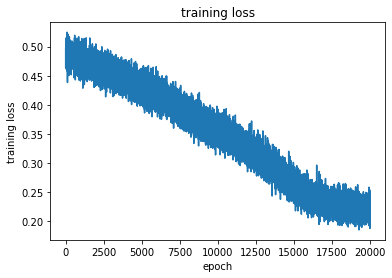

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1.title.set_text("training loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("training loss")
ax1.plot(np.array(x), np.array(x_loss))

# ax2.title.set_text("std-dev of correlations")
# ax2.set_xlabel("epoch")
# ax2.set_ylabel("std-dev")
# ax2.plot(np.array(x), np.array(y_score_std))

In [14]:
from utils import image, visualize

In [15]:
bordersize = 20
N = 16
for mp, correlations in ds.take(1):
    pred = regressor(correlations)
    pred = tf.reshape(pred, [-1, 9, 2])

mp = mp.numpy()
print(mp.shape)
pred = pred.numpy()
print(pred.shape)

white_board = np.ones([N,64+2*bordersize,64+2*bordersize,3], np.float32)
motion_parameters = np.array(list(map(lambda image, mp : visualize.draw_arrow(image,bordersize,mp) 
                                     ,white_board, mp)))
predictions = np.array(list(map(lambda image, parameter : visualize.draw_arrow(image,bordersize,parameter) 
                                         ,white_board, pred)))

images = np.stack([motion_parameters, predictions], axis=1)

(16, 9, 2)
(16, 9, 2)


In [16]:
def show_image(images, figsize=(20, 100)):
    rows, cols = images.shape[:2]
    fig = plt.figure(figsize=figsize)
    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        image = images[row][col]
        fig.add_subplot(rows, cols, i + 1).imshow(image)
    plt.show()

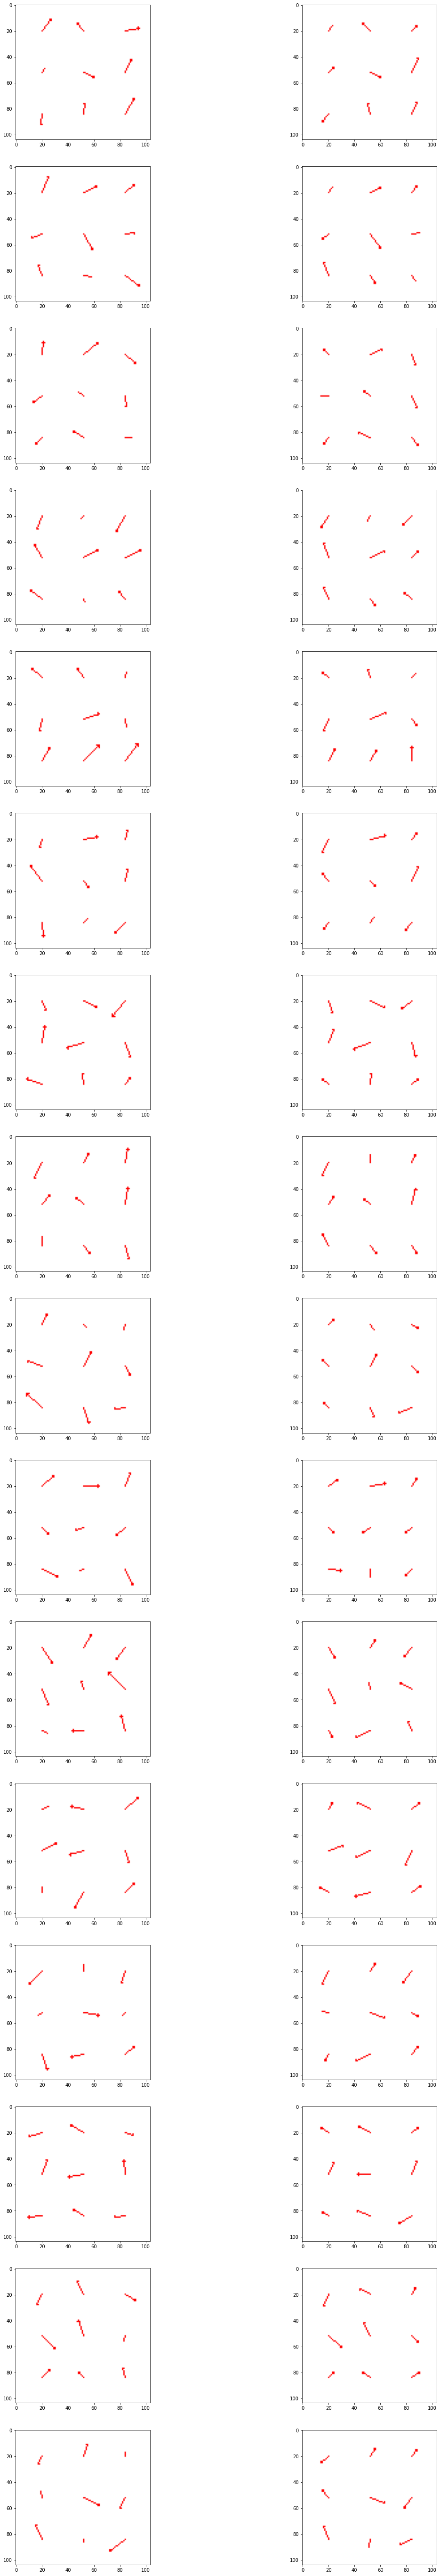

In [17]:
show_image(images)

# Sub-domain matching

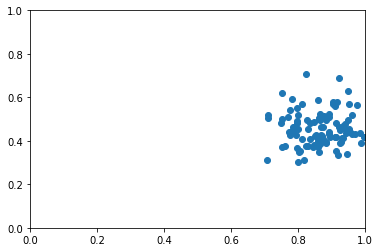

In [241]:
def gen_motion_parameter(shape):
    while True:
        yield (tf.random.uniform(shape) - 0.5) * 2 * 0.2

gen = partial(gen_motion_parameter, (9,2))
ds = tf.data.Dataset.from_generator(gen, output_types=tf.float32)

def data_process(motion_parameters, axay, map_size):
    motion_parameters = motion_parameters.numpy()
    bxby = sim.get_tgt_from_src(motion_parameters, axay, map_size)
    axybxy = np.concatenate([axay, bxby], axis = -1)
    correlations = sim.generate_correlations(axybxy, map_size)
    return motion_parameters, correlations

# axay = np.random.uniform(low=0.0, high=1.0, size=[100, 2])
# axay = np.clip(axay, 0, 1)
axay = np.random.uniform(low=0.0, high=1.0, size=[1, 2]) + np.random.normal(loc=0.0, scale=0.07, size=[100,2])
axay = np.clip(axay, 0, 1)
# axay = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
#                            [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
#                            [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
plt.scatter(axay[:,0], axay[:,1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

map_size = (16, 16)
axay = axay*(map_size[1]-1, map_size[0]-1)
axay = axay.astype(np.int32)

py_func = partial(data_process, axay = axay, map_size = map_size)
ds = ds.map(map_function)
ds = ds.batch(128)

In [242]:
bordersize = 20
N = 16
for mp, correlations in ds.take(1):
    pred = regressor(correlations)
    pred = tf.reshape(pred, [-1, 9, 2])

mp = mp.numpy()
print(mp.shape)
pred = pred.numpy()
print(pred.shape)

white_board = np.ones([N,64+2*bordersize,64+2*bordersize,3], np.float32)
motion_parameters = np.array(list(map(lambda image, mp : visualize.draw_arrow(image,bordersize,mp) 
                                     ,white_board, mp)))
predictions = np.array(list(map(lambda image, parameter : visualize.draw_arrow(image,bordersize,parameter) 
                                         ,white_board, pred)))

images = np.stack([motion_parameters, predictions], axis=1)

(128, 9, 2)
(128, 9, 2)


# Loss

In [243]:
def _loss_fn(pred, label):
    loss = tf.sqrt(tf.reduce_mean(tf.pow(pred - label, 2), axis=[-1, -2]))
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

_loss_fn(pred, mp).numpy()

0.13501698

In [244]:
def show_image(images, figsize=(20, 100)):
    rows, cols = images.shape[:2]
    fig = plt.figure(figsize=figsize)
    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        image = images[row][col]
        fig.add_subplot(rows, cols, i + 1).imshow(image)
    plt.show()

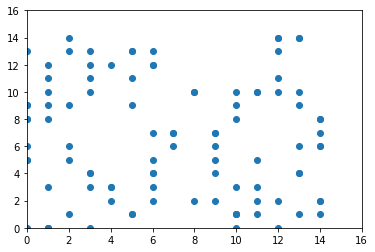

In [225]:
plt.scatter(axay[:,0], axay[:,1])
plt.xlim(0, 16)
plt.ylim(0, 16)
plt.show()

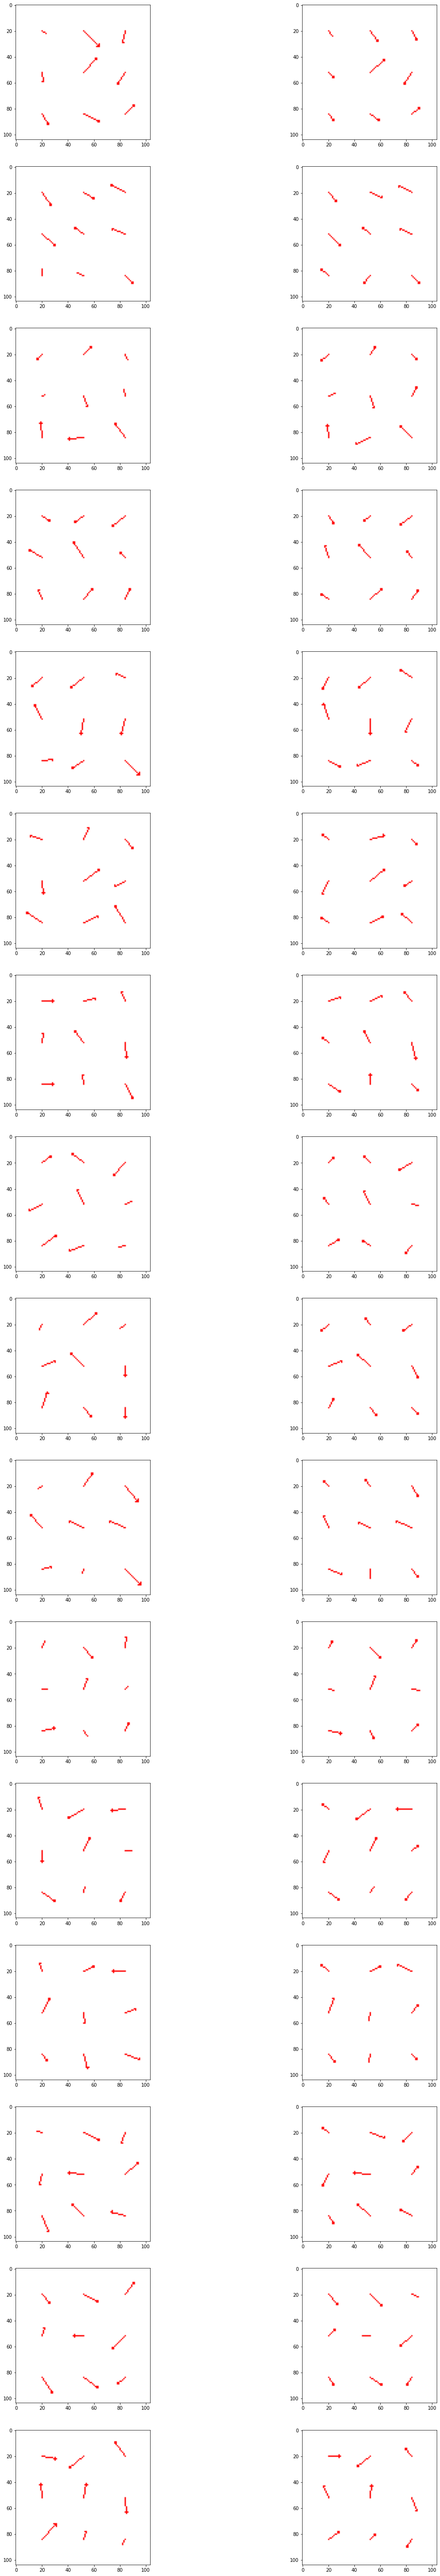

In [220]:
show_image(images)

# Training more and change learning rate

In [ ]:
x = []
x_loss = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
for epoch in range(20000):
    i+= 1
    x.append(i)
    for mp, correlations in ds.take(1):
        with tf.GradientTape() as tape:
            pred = regressor(correlations)
            pred = tf.reshape(pred, [-1, 9, 2])
            loss = loss_fn(pred, mp)
            x_loss.append(loss)
        gradients = tape.gradient(loss, regressor.trainable_variables)
        optimizer.apply_gradients(zip(gradients, regressor.trainable_variables)) 
        if i % 100 == 0:
            print(i, "iter loss : ", loss.numpy())

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1.title.set_text("training loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("training loss")
ax1.plot(np.array(x), np.array(x_loss))

# ax2.title.set_text("std-dev of correlations")
# ax2.set_xlabel("epoch")
# ax2.set_ylabel("std-dev")
# ax2.plot(np.array(x), np.array(y_score_std))

In [ ]:
x = []
x_loss = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
for epoch in range(20000):
    i+= 1
    x.append(i)
    for mp, correlations in ds.take(1):
        with tf.GradientTape() as tape:
            pred = regressor(correlations)
            pred = tf.reshape(pred, [-1, 9, 2])
            loss = loss_fn(pred, mp)
            x_loss.append(loss)
        gradients = tape.gradient(loss, regressor.trainable_variables)
        optimizer.apply_gradients(zip(gradients, regressor.trainable_variables)) 
        if i % 100 == 0:
            print(i, "iter loss : ", loss.numpy())

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1.title.set_text("training loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("training loss")
ax1.plot(np.array(x), np.array(x_loss))

# ax2.title.set_text("std-dev of correlations")
# ax2.set_xlabel("epoch")
# ax2.set_ylabel("std-dev")
# ax2.plot(np.array(x), np.array(y_score_std))

In [ ]:
for mp, corr in ds.take(1):
    pred = regressor(corr)
    pred = tf.reshape(pred, [-1, 9, 2])

In [ ]:
pred[0]

In [ ]:
mp[0]

In [ ]:
tf.sqrt(tf.reduce_sum(tf.pow(pred[0] - mp[0], 2), axis=[-1, -2]))

In [ ]:
pred[0]*mp[0] > 0

In [ ]:
def loss_fn(pred, label):
    loss = tf.sqrt(tf.reduce_sum(tf.pow(pred - label, 2), axis=[-1, -2]))
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

# Smaller grid map

In [ ]:
map_size = (3,3)

In [ ]:
gen = partial(gen_motion_parameter, (9,2))
ds = tf.data.Dataset.from_generator(gen, output_types=tf.float32)